In [1]:
from Utils.FS import file
from Utils.tensorflow_helper import show_graph
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from scipy.sparse import coo_matrix, dok_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from nltk.corpus import stopwords
import tensorflow as tf
import math
import TextPreprocess.words2dict as words2dict
from tensorflow.python.layers import core as layers_core
from tensorflow.python.client import timeline
import time
from DataLoader import GloVe
from TextPreprocess.sequences import Sequences
from TextPreprocess.Tokenizer.RegExp import tokenize
import Utils.pandas_helper as ph

In [2]:
np.random.seed(1234)
WORD_DIM = 300

In [3]:
train = file.read('data/Quora/train.csv')

In [4]:
glove = GloVe.load2('./data/GloVe/glove.6B.{}d.txt'.format(WORD_DIM))

Start: Loading Glove Model
End: Loaded 400000 rows.


In [5]:
# emb: Symbol to float32 of fixed DIMENSION
# Create an index mapping, index to symbol, symbol to index

class Embedding:
    def __init__(self, emb, verbose = False):
        # assert emb is dictionary and each entry has same dimension
        self.emb = emb
        self.dim = len(self.emb[list(self.emb.keys())[0]])
        self.emb['<UNK>'] = [0. for i in range(self.dim)]
        self.emb['<PAD>'] = [1. for i in range(self.dim)]
        self.emb['<GO>'] = [-1. for i in range(self.dim)]
        
        self.build_dicts()
        
        if verbose:
            self.describe()
        
    def describe(self):
        print('Embedding Dimension: {}'.format(self.dim))
        print('Embedding Symbols: {}'.format(len(self.emb)))
        print('Index to symbol: {}'.format([(i, self.idx2Sym[i]) for i in range(10)]))
        
    def getIndex(self, symbol):
        if symbol in self.sym2Idx:
            return self.sym2Idx[symbol]
        else:
            return self.sym2Idx['<UNK>']

    def getEmb(self, symbol):
        return self.emb[self.idx2Sym[self.getIndex(symbol)]]
    
    def getSymbols(self, indices):
        return [self.idx2Sym[idx] for idx in indices]

    def getNumpyArray(self):
        return np.array([self.emb[self.idx2Sym[idx]] for idx in range(len(self.emb))])
    
    def build_dicts(self):
        self.sym2Idx = {}
        index = 0
        for key in self.emb.keys():
            self.sym2Idx[key] = index
            index += 1
            
        self.idx2Sym = { v:k for k, v in self.sym2Idx.items()}

glove_emb = Embedding(glove, verbose=True)

Embedding Dimension: 300
Embedding Symbols: 400003
Index to symbol: [(0, '65-35'), (1, 'sawley'), (2, 'miamisburg'), (3, 'atea'), (4, 'run-down'), (5, 'beyk'), (6, 'ca-125'), (7, 'foxes'), (8, '4-to-3'), (9, 'shenandoah')]


In [6]:
# print(train['is_duplicate'].describe())
# print(train.sample(15))
# print(train.iloc[261849]['question1'])
# print(train.iloc[261849]['question2'])
# print(train.iloc[261849]['is_duplicate'])
print('Number of training samples: ', len(train))

Number of training samples:  404290


In [7]:
def preprocess(string):
    return [glove_emb.getIndex(token.lower()) for token in tokenize(string)]

def preprocessLabels(val):
    return [1., 0.] if val == 0 else [0., 1.]

In [8]:
q1 = ph.parallel_apply(train['question1'].astype(str), preprocess)
q2 = ph.parallel_apply(train['question2'].astype(str), preprocess)
#labels = ph.parallel_apply(train['is_duplicate'].astype('float32'), preprocessLabels)
labels = train['is_duplicate'].astype('float32')

Size: 404290
Longest sequence length: 140


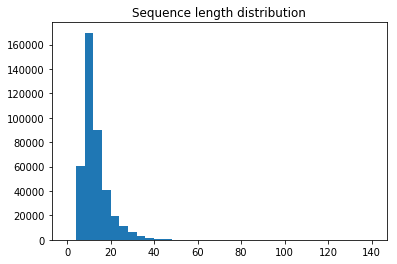

Size: 404290
Longest sequence length: 271


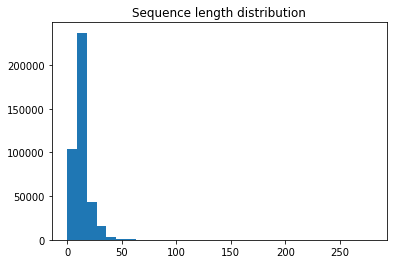

In [9]:
# Turns iteratable of symbols into padded batch
from functools import lru_cache

class Batcher:
    def __init__(self, sequences, verbose = False):
        self.seqs = sequences
        self.verbose = verbose
        self.size = len(self.seqs)
        self.seq_lens = [len(seq) for seq in self.seqs]
        
        if self.verbose:
            self.describe()
    
    @lru_cache(maxsize=None)
    def max_length(self):
        return max(self.seq_lens)
    
    @lru_cache(maxsize=None)
    def longgest_sequence(self):
        for seq in self.seqs:
            if len(seq) == self.max_length():
                return seq
    
    def describe(self):
        print('Size: {}'.format(self.size))
        print("Longest sequence length: {}".format(self.max_length()))
        bin_width = max(1, self.max_length() // 30)
        plt.hist(self.seq_lens, range(0, self.max_length() + bin_width, bin_width))
        plt.title('Sequence length distribution')
        plt.show()
        
    def batchPadding(self, batch, padding_symbol):
        size = max([len(record) for record in batch])
        result = np.full((len(batch), size), padding_symbol)
        for i in range(len(batch)):
            result[i][:len(batch[i])] = batch[i]
        return result

    def batchMask(self, batch):
        size = max([len(record) for record in batch])
        result = np.full((len(batch), size), 0.0)
        for i in range(len(batch)):
            result[i][:len(batch[i])] = 1.0
        return result
        
    # Same length within the batch, stuffed with padding symbol
    def generator(self, padding_symbol, batch_size=32, epouch=-1):
        train = []
        length = []
        while(epouch < 0 or epouch > 0):
            for seq in self.seqs:
                train.append([sym for sym in seq])
                length.append(len(seq))
                if(len(train) == batch_size):
                    yield self.batchPadding(train, padding_symbol), length, self.batchMask(train)
                    train = []
                    length = []
            epouch -= 1
            if self.verbose:
                print('epouch done...')
                
                

class Batcher2:
    def __init__(self, sequences, verbose = False):
        self.seqs = sequences             

    def generator(self, batch_size=32, epouch=-1):
        train = []
        while(epouch < 0 or epouch > 0):
            for sym in self.seqs:
                train.append([sym])
                if(len(train) == batch_size):
                    yield train
                    train = []
            epouch -= 1
            print('epouch done...')
    
q1_batcher = Batcher(q1, verbose=True)
q2_batcher = Batcher(q2, verbose=True)
labels_batcher = Batcher2(labels)

In [10]:
EMBEDDING = glove_emb.getNumpyArray()

LV1_DIM = 10
LV2_STEP = 1
LV2_DIM = 200

In [11]:
#IN (batch, time, dim)
def simple_dynamic_rnn(cell, inputs, lengths, scope):
     with tf.variable_scope(scope):
        outputs, states = tf.nn.dynamic_rnn(
            cell, 
            inputs, 
            initial_state = cell.zero_state(tf.shape(inputs)[0], dtype=tf.float32),
            dtype = tf.float32, 
            sequence_length = lengths
        )
        
        batch_size = tf.shape(inputs)[0]
        step_size = tf.shape(inputs)[1]
        indices = tf.range(0, batch_size) * step_size + (lengths - 1)
        gather = tf.reshape(tf.gather(tf.reshape(outputs, [-1, cell.output_size]), indices), [-1, cell.output_size])
        return gather
#OUT (batch, dim)

In [12]:
graph = tf.Graph()
with graph.as_default():
    
    with tf.variable_scope("Inputs"):
    
        #IN
        inputs = [tf.placeholder(tf.int32, (None, None), name = "Q{}_Word_Indices".format(i+1)) for i in range(2)]
        #OUT: (batch, time) int32
        
        batch_size = [tf.shape(inputs[i], name= "Q{}_Batch_Size".format(i+1))[0] for i in range(2)]
        steps = [tf.shape(inputs[i], name= "Q{}_Steps".format(i+1))[1] for i in range(2)]
        
        #IN
        input_lengths = [tf.placeholder(tf.int32, (None), name = "Q{}_Lengths".format(i+1)) for i in range(2)]
        #OUT: (batch) int32
        
        truth = tf.placeholder(tf.float32, (None, 1), name = "labels")
        
    with tf.variable_scope("Embedding"):
        
        embeddings = tf.get_variable("embeddings", shape=EMBEDDING.shape, initializer=tf.constant_initializer(EMBEDDING), trainable=False)
        encoder_inputs = [tf.nn.embedding_lookup(embeddings, inputs[i]) for i in range(2)] 
        #OUT: (batch, time, dim) float32
        
    """
    with tf.variable_scope("Level_1_RNN"):
        
        rnn_output_1 = [[simple_dynamic_rnn(
                    cell = tf.contrib.rnn.GRUCell(
                        LV1_DIM, 
                        reuse = True if i == 1 else None
                    ),
                    inputs = encoder_inputs[i],
                    lengths = input_lengths[i],
                    scope = '{}'.format(step)
                ) for step in range(LV2_STEP)] for i in range(2)]
        # OUT: rnn_output[LV2_STEP][LV1_DIM]
        # (time, batch, dim) float32
    """

    with tf.variable_scope("Level_2_RNN"):
        
        #rnn_input_2 = [tf.transpose(rnn_output_1[i], [1, 0, 2]) for i in range(2)]
        # (batch, time, dim)
        
        rnn_output_2 = [simple_dynamic_rnn(
                    cell = tf.contrib.rnn.LSTMCell(
                        LV2_DIM,
                        reuse = True if i == 1 else None
                    ),
                    #inputs = rnn_input_2[i],
                    #lengths = tf.fill(tf.shape(input_lengths[i]), LV2_STEP),
                    inputs = encoder_inputs[i],
                    lengths = input_lengths[i],
                    scope = 'L2',
                ) for i in range(2)]
        # OUT: [2](batch, LV2_DIM)


    with tf.variable_scope("Final_Prediction"):
        final_input = tf.concat([rnn_output_2[0], rnn_output_2[1]], 1)
        
        print(final_input)
        
        predict = tf.layers.dense(
            inputs=final_input,
            units=1,
            activation=tf.nn.sigmoid,
            use_bias=True,
            kernel_initializer=None,
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            trainable=True,
            name=None,
            reuse=None
        );
        
    loss = tf.reduce_mean(tf.contrib.keras.losses.binary_crossentropy(truth, predict))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    saver = tf.train.Saver()
    tvars = tf.trainable_variables()

Tensor("Final_Prediction/concat:0", shape=(?, 400), dtype=float32)


/home/hoiy927/project/tf_playground/tf_playground/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
#show_graph(graph.as_graph_def())

In [ ]:
num_steps = 2000000
MODEL = './model/q.ckpt'
BATCH_SIZE = 2048

q1_gen = q1_batcher.generator(glove_emb.getIndex('<PAD>'), batch_size=BATCH_SIZE)
q2_gen = q2_batcher.generator(glove_emb.getIndex('<PAD>'), batch_size=BATCH_SIZE)
labels_gen = labels_batcher.generator(batch_size=BATCH_SIZE)

In [ ]:
DEBUG_SIZE = 100

with tf.Session(graph=graph) as session:
    try:
        saver.restore(session, MODEL)
        print('Restored training...')
    except:
        session.run(tf.global_variables_initializer())
        print('Restarting training...')
    
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()
    

    
    #tvars_vals = session.run(tvars)
    #for var, val in zip(tvars, tvars_vals):
    #    print(var.name, val)  # Prints the name of the variable alongside its value.

    for name in session.run( tf.report_uninitialized_variables( tf.global_variables( ) ) ):
        print(name)
    
    
    average_loss = 0
    average_max_loss = 0
    start = time.time()
    
    for step in range(num_steps):
        
        train_q1, train_q1_lengths, _ = next(q1_gen)
        train_q2, train_q2_lengths, _ = next(q2_gen)
        train_labels = next(labels_gen)
        
        feed_dict = {
            inputs[0]: train_q1,
            inputs[1]: train_q2,
            input_lengths[0]: train_q1_lengths,
            input_lengths[1]: train_q2_lengths,
            truth: train_labels
        }
        
        #_, loss_val = session.run([optimizer, loss], feed_dict=feed_dict, options=run_options, run_metadata=run_metadata)
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % DEBUG_SIZE == 0:
            if step > 0:
                average_loss /= DEBUG_SIZE
                print('Total time for {0} steps: {1:.2f}s, each step: {2:.2f}s'.format(DEBUG_SIZE, time.time()-start, (time.time()-start) / DEBUG_SIZE))
                print('Average mean loss at step ', step, ': ', average_loss)
                average_loss = 0
                start = time.time()
                
        if step % DEBUG_SIZE == 0:
            save_path = saver.save(session, MODEL)
            print("Model saved in file: %s" % save_path)
            
            # Create the Timeline object, and write it to a json
            tl = timeline.Timeline(run_metadata.step_stats)
            ctf = tl.generate_chrome_trace_format()
            with open('timeline.json', 'w') as f:
                f.write(ctf)


INFO:tensorflow:Restoring parameters from ./model/q.ckpt
Restored training...
Model saved in file: ./model/q.ckpt
Total time for 100 steps: 743.06s, each step: 7.43s
Average mean loss at step  100 :  0.669999719262
Model saved in file: ./model/q.ckpt
